In [1]:
# Dependencies
import numpy as np
import pandas as pd

In [2]:
from sqlalchemy import create_engine
from hold import connection_string

In [3]:
engine = create_engine(f'{connection_string}', encoding='iso-8859-1', connect_args={'connect_timeout': 10})

In [4]:
gtdDF = pd.read_sql_table('global_terrorism', con= engine)

In [5]:
gtdDF.head()

,iyear,imonth,iday,date,country_txt,region_txt,provstate,city,latitude,longitude,...,claimmode_txt,weaptype1_txt,weapsubtype1_txt,weaptype2_txt,weapsubtype2_txt,kidhijcountry,ransom,nkill,nwound,index1
0,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,0.0,7.0,1.0
1,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,None,Firearms,Unknown Gun Type,None,None,None,0.0,0.0,7.0,2.0
2,2000,1,1,2000-01-01,India,South Asia,Jammu and Kashmir,Udhampur,32.93,75.14,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,1.0,2.0,3.0
3,2000,1,1,2000-01-01,Kosovo,Eastern Europe,Kosovo (Province),Peje,42.66,20.31,...,None,Explosives/Bombs/Dynamite,Unknown Explosive Type,None,None,None,NaN,0.0,1.0,4.0
4,2000,1,1,2000-01-01,Somalia,Sub-Saharan Africa,Banaadir,Mogadishu,2.11,45.39,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,6.0,10.0,5.0


In [6]:
AttackTypesDF = gtdDF[['index1','attacktype1_txt']]
AttackTypesDF.head()

,index1,attacktype1_txt
0,1.0,Armed Assault
1,2.0,Hostage Taking (Kidnapping)
2,3.0,Armed Assault
3,4.0,Bombing/Explosion
4,5.0,Armed Assault


In [7]:
filterlist = ['Unknown']
AttackTypesFilterDF = AttackTypesDF[~AttackTypesDF['attacktype1_txt'].isin(filterlist)]
AttackTypesFilterDF.head()

,index1,attacktype1_txt
0,1.0,Armed Assault
1,2.0,Hostage Taking (Kidnapping)
2,3.0,Armed Assault
3,4.0,Bombing/Explosion
4,5.0,Armed Assault


In [8]:
AttackTypes2DF = pd.get_dummies(AttackTypesFilterDF)
AttackTypes2DF.head()

,index1,attacktype1_txt_Armed Assault,attacktype1_txt_Assassination,attacktype1_txt_Bombing/Explosion,attacktype1_txt_Facility/Infrastructure Attack,attacktype1_txt_Hijacking,attacktype1_txt_Hostage Taking (Barricade Incident),attacktype1_txt_Hostage Taking (Kidnapping),attacktype1_txt_Unarmed Assault
0,1.0,1,0,0,0,0,0,0,0
1,2.0,0,0,0,0,0,0,1,0
2,3.0,1,0,0,0,0,0,0,0
3,4.0,0,0,1,0,0,0,0,0
4,5.0,1,0,0,0,0,0,0,0


In [9]:
AttackTypesMergeDF = result = pd.merge(AttackTypes2DF,AttackTypesFilterDF[['index1','attacktype1_txt']],on='index1')
AttackTypesMergeDF = AttackTypesMergeDF.rename(columns={
    'attacktype1_txt_Armed Assault':'Armed Assault', 
    'attacktype1_txt_Assassination': 'Assassination',
    'attacktype1_txt_Bombing/Explosion':'Bombing/Explosion',
    'attacktype1_txt_Facility/Infrastructure Attack':'Facility/Infrastructure Attack',
    'attacktype1_txt_Hijacking':'Hijacking',
    'attacktype1_txt_Hostage Taking (Barricade Incident)':'Hostage Taking (Barricade Incident)',
    'attacktype1_txt_Hostage Taking (Kidnapping)':'Hostage Taking (Kidnapping)',
    'attacktype1_txt_Unarmed Assault':'Unarmed Assault',
    })
AttackTypesMergeDF.head()

,index1,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault,attacktype1_txt
0,1.0,1,0,0,0,0,0,0,0,Armed Assault
1,2.0,0,0,0,0,0,0,1,0,Hostage Taking (Kidnapping)
2,3.0,1,0,0,0,0,0,0,0,Armed Assault
3,4.0,0,0,1,0,0,0,0,0,Bombing/Explosion
4,5.0,1,0,0,0,0,0,0,0,Armed Assault


In [10]:
# Assign X (data) and y (target)
X = AttackTypesMergeDF.drop(["index1","attacktype1_txt",], axis=1)
y = AttackTypesMergeDF["attacktype1_txt"]
feature_names = X.columns
print(X.shape, y.shape)

(89722, 8) (89722,)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, stratify=y)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
from keras.models import Sequential
from keras.layers import Dense

# Create model and add layers
model = Sequential()
# input dimensions should be X.shape
model.add(Dense(units=128, activation='relu', input_dim=8))
model.add(Dense(units=128, activation='relu'))
# Below units should be the value of X.shape
model.add(Dense(units=8, activation='softmax'))

In [13]:
# Compile and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=16,
    shuffle=True,
    verbose=2
)

Epoch 1/16
 - 7s - loss: 0.0198 - acc: 0.9985
Epoch 2/16
 - 7s - loss: 7.8542e-06 - acc: 1.0000
Epoch 3/16
 - 7s - loss: 9.6679e-07 - acc: 1.0000
Epoch 4/16
 - 6s - loss: 2.4862e-07 - acc: 1.0000
Epoch 5/16
 - 7s - loss: 1.3730e-07 - acc: 1.0000
Epoch 6/16
 - 6s - loss: 1.2156e-07 - acc: 1.0000
Epoch 7/16
 - 5s - loss: 1.1949e-07 - acc: 1.0000
Epoch 8/16
 - 4s - loss: 1.1921e-07 - acc: 1.0000
Epoch 9/16
 - 4s - loss: 1.1921e-07 - acc: 1.0000
Epoch 10/16
 - 4s - loss: 1.1921e-07 - acc: 1.0000
Epoch 11/16
 - 4s - loss: 1.1921e-07 - acc: 1.0000
Epoch 12/16
 - 5s - loss: 1.1921e-07 - acc: 1.0000
Epoch 13/16
 - 6s - loss: 1.1921e-07 - acc: 1.0000
Epoch 14/16
 - 5s - loss: 1.1921e-07 - acc: 1.0000
Epoch 15/16
 - 7s - loss: 1.1921e-07 - acc: 1.0000
Epoch 16/16
 - 7s - loss: 1.1921e-07 - acc: 1.0000


In [14]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 1.1920928955078125e-07, Accuracy: 1.0


In [15]:
encoded_predictions = model.predict_classes(X_test_scaled[:8])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:20])}")

Predicted classes: ['Bombing/Explosion' 'Bombing/Explosion' 'Assassination' 'Armed Assault'
 'Armed Assault' 'Armed Assault' 'Hostage Taking (Kidnapping)'
 'Bombing/Explosion']
Actual Labels: ['Bombing/Explosion', 'Bombing/Explosion', 'Assassination', 'Armed Assault', 'Armed Assault', 'Armed Assault', 'Hostage Taking (Kidnapping)', 'Bombing/Explosion', 'Armed Assault', 'Assassination', 'Bombing/Explosion', 'Bombing/Explosion', 'Facility/Infrastructure Attack', 'Hostage Taking (Kidnapping)', 'Bombing/Explosion', 'Hostage Taking (Kidnapping)', 'Bombing/Explosion', 'Bombing/Explosion', 'Bombing/Explosion', 'Bombing/Explosion']


In [17]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.31825387, 'Armed Assault'),
 (0.2888873, 'Bombing/Explosion'),
 (0.13535126, 'Assassination'),
 (0.11294581, 'Hostage Taking (Kidnapping)'),
 (0.110584, 'Facility/Infrastructure Attack'),
 (0.016390176, 'Unarmed Assault'),
 (0.0090687135, 'Hostage Taking (Barricade Incident)'),
 (0.008518882, 'Hijacking')]

In [19]:
DLAttackTypeAttacksDF = pd.DataFrame(sorted(zip(model.feature_importances_, feature_names), reverse=True), 
                               columns = ['Probability', 'Attack Type'])
DLAttackTypeAttacksDF

,Probability,Attack Type
0,0.318254,Armed Assault
1,0.288887,Bombing/Explosion
2,0.135351,Assassination
3,0.112946,Hostage Taking (Kidnapping)
4,0.110584,Facility/Infrastructure Attack
5,0.016390,Unarmed Assault
6,0.009069,Hostage Taking (Barricade Incident)
7,0.008519,Hijacking


In [20]:
pies = DLAttackTypeAttacksDF['Attack Type'].head(6)
pie_slices = DLAttackTypeAttacksDF['Probability'].head(6)
colors = ["lightskyblue","orange","pink","yellowgreen","lightcoral","silver","yellow",
          "lightgreen","wheat","khaki"]
explode = (0.1,0,0,0,0,0)

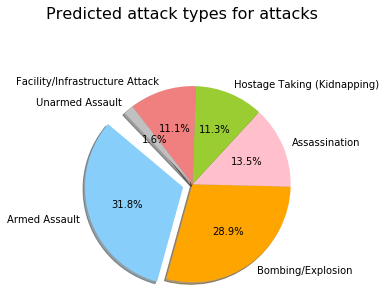

In [21]:
# Tell matplotlib to create a pie chart based upon the above data
pyplot.pie(pie_slices, explode=explode, labels=pies, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=140)
# Create axes which are equal so we have a perfect circle
pyplot.axis("equal")
# Save an image of our chart and print the final product to the screen

pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML15_AttackType_Attacks_Pie_DL")
pyplot.suptitle('Predicted attack types for attacks', size=16, y=1.12) 
pyplot.show()

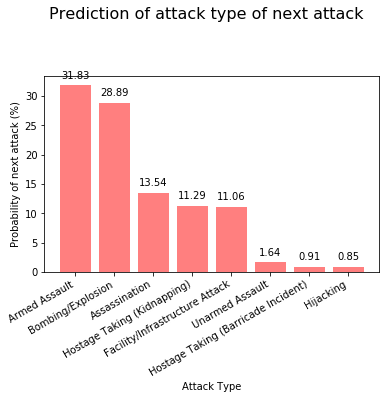

In [22]:
y_axis = DLAttackTypeAttacksDF['Probability']*100
x_axis = DLAttackTypeAttacksDF['Attack Type']
fig, ax = pyplot.subplots()
# plot
ax.bar(x_axis, y_axis, color='r', alpha=0.5, align="center")

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()

# Labels for x and y axes
pyplot.xlabel("Attack Type")
pyplot.ylabel("Probability of next attack (%)")

# Show the values of each probability on plot
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)

# Save an image of our chart and print the final product to the screen
pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML15_AttackType_Attacks_Bar_DL")
# Title for the chart
pyplot.suptitle('Prediction of attack type of next attack', size=16, y=1.12) 
pyplot.show()
